#### Analyzing Neural Time Series Data
Python code for Chapter 19 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [11]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.stats import zscore
from scipy.io import loadmat
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d
from numpy.random import rand, randn, permutation, choice

In [12]:
# Define a function to plot polar vectors
def plot_polar_vectors(angles, lengths=None, average_angle=None, average_length=None):
    if lengths is None:
        lengths = np.ones_like(angles)
    for angle, length in zip(angles, lengths):
        plt.polar([0, angle], [0, length])
    if average_angle is not None and average_length is not None:
        plt.polar([0, average_angle], [0, average_length])

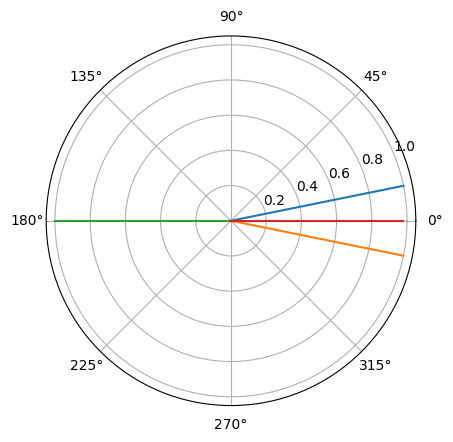

In [13]:
# Figure 19.1

# Define angles
a = [0.2, 2*np.pi-.2]

# Plot unit vectors defined by those angles
plt.figure()
plot_polar_vectors(a)
# Plot a unit vector with the average angle
plot_polar_vectors([np.mean(a)], [1])
# Plot the average vector
mean_vector = np.mean(np.exp(1j*np.array(a)))
plot_polar_vectors([np.angle(mean_vector)], [np.abs(mean_vector)])
plt.show()

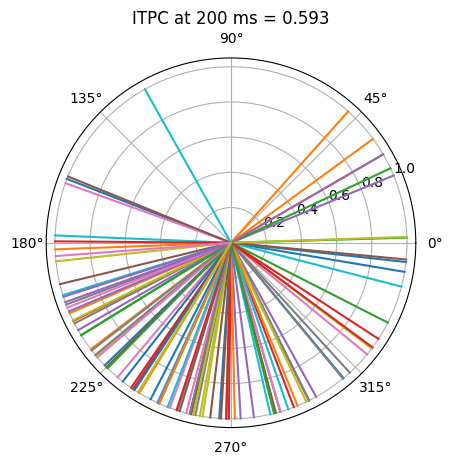

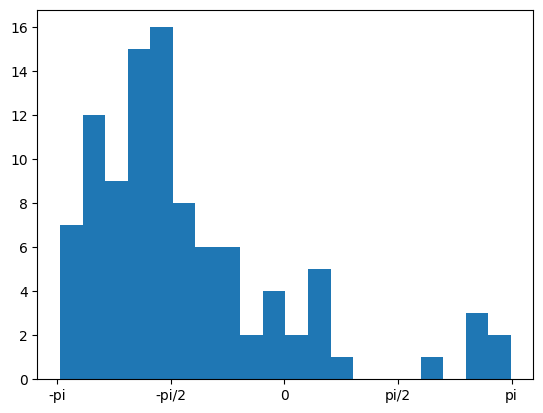

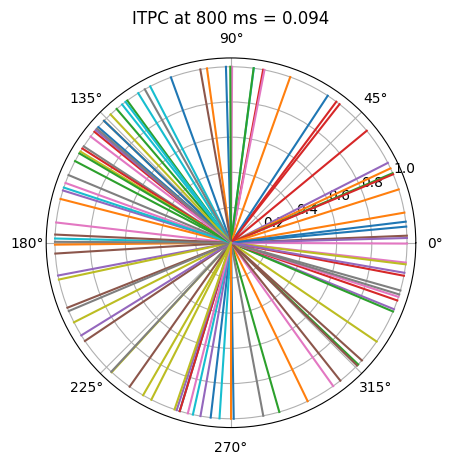

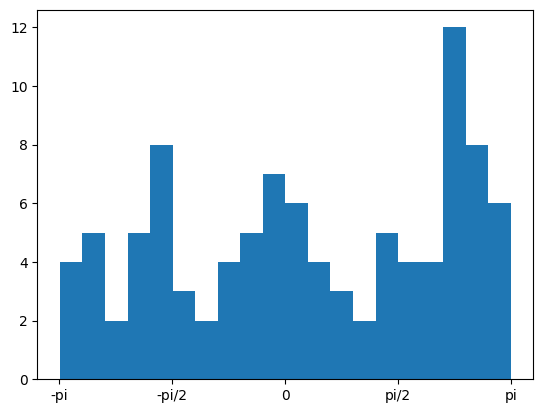

In [89]:
# Figure 19.2

# Load sample scalp EEG data
EEG = loadmat('../data/sampleEEGdata.mat')['EEG'][0,0]

# Center frequency
centerfreq = 12  # in Hz
chan2plot = 'Pz'
times2plot = [200, 800]  # in ms, from stimulus onset

# Define convolution parameters
n_wavelet = EEG['pnts'][0][0]
n_data = EEG['pnts'][0][0] * EEG['trials'][0][0]
n_convolution = n_wavelet + n_data - 1
n_conv_pow2 = 2**np.ceil(np.log2(n_convolution))

# Create wavelet
time = np.arange(-(n_wavelet/EEG['srate'][0][0]/2), n_wavelet/EEG['srate'][0][0]/2, 1/EEG['srate'][0][0])
wavelet = np.exp(2*1j*np.pi*centerfreq*time) * np.exp(-time**2 / (2 * ((4 / (2 * np.pi * centerfreq))**2))) / centerfreq

# Get FFT of data
chanidx = EEG['chanlocs'][0]['labels']==chan2plot
eegfft = fft(np.reshape(EEG['data'][chanidx,:,:], -1, 'F'), n=int(n_conv_pow2))

# Convolution
eegconv = ifft(fft(wavelet, n=int(n_conv_pow2)) * eegfft)
eegconv = eegconv[:n_convolution]
eegconv = np.reshape(eegconv[int(np.floor((n_wavelet-1)/2)):-int(np.ceil((n_wavelet-1)/2))], (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')

# Plot
for subploti, timepoint in enumerate(times2plot):
    plt.figure()
    idx = np.argmin(np.abs(EEG['times'][0] - timepoint))
    plot_polar_vectors(np.angle(eegconv[idx,:]), np.ones(EEG['trials'][0][0]))
    plt.title(f'ITPC at {timepoint} ms = {np.round(np.abs(np.mean(np.exp(1j*np.angle(eegconv[idx,:])))), 3)}')
    
    plt.figure()
    plt.hist(np.angle(eegconv[idx,:]), bins=20)
    plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['-pi', '-pi/2', '0', 'pi/2', 'pi'])
plt.show()

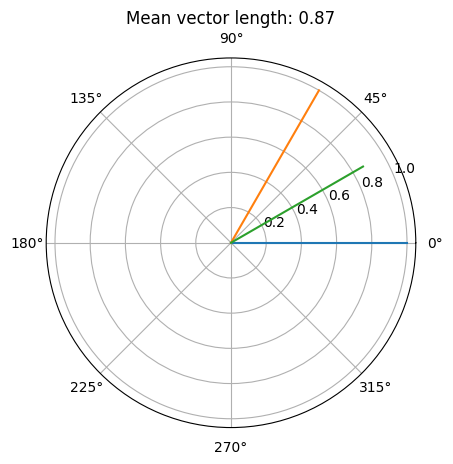

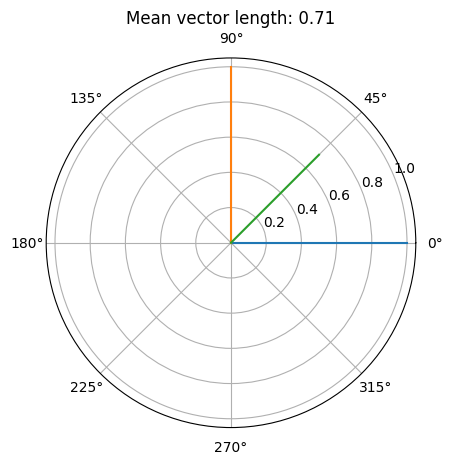

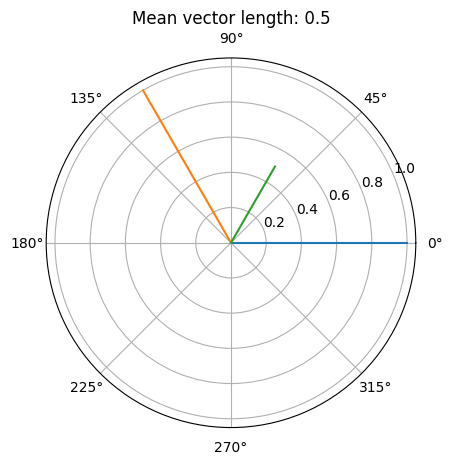

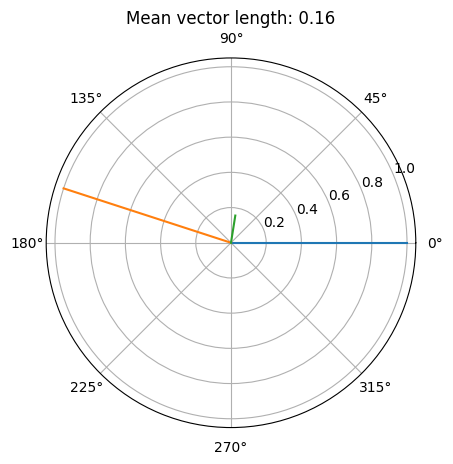

In [65]:
# Figure 19.3

vectors = [[0, np.pi/3], [0, np.pi/2], [0, 2*np.pi/3], [0, np.pi*.9]]

for i, vec in enumerate(vectors):
    plt.figure()
    # Plot individual unit vectors
    plot_polar_vectors(vec)
    # Plot mean vector
    meanvect = np.mean(np.exp(1j*np.array(vec)))
    plot_polar_vectors([np.angle(meanvect)], [np.abs(meanvect)])
    plt.title(f'Mean vector length: {np.round(np.abs(meanvect), 2)}')
plt.show()

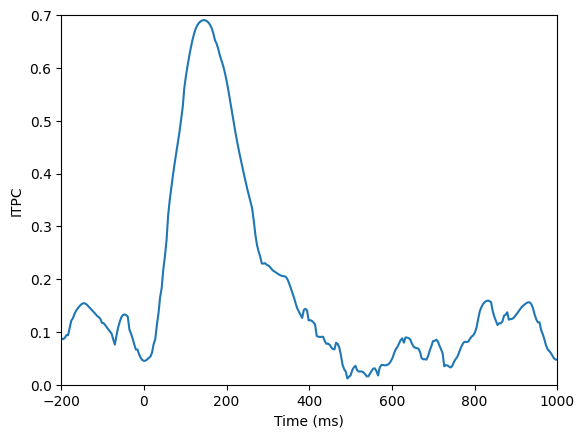

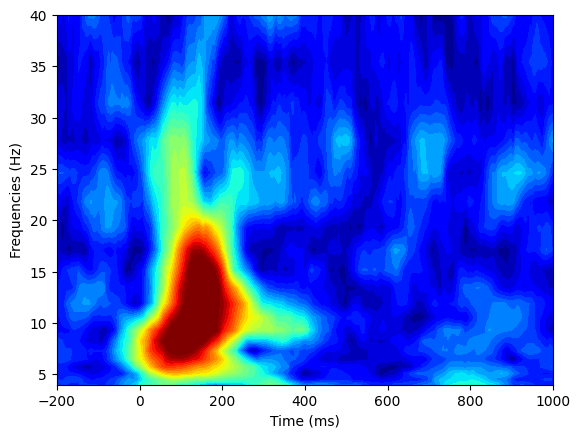

In [82]:
# Figure 19.4

# Get FFT of data
chan2plot = 'Pz'
centerfreq = 12  # in Hz
chanidx = EEG['chanlocs'][0]['labels']==chan2plot
eegfft = fft(np.reshape(EEG['data'][chanidx,:,:], -1, 'F'), n=int(n_conv_pow2))

# ITPC at one frequency band
wavelet = np.exp(2*1j*np.pi*centerfreq*time) * np.exp(-time**2 / (2 * ((4 / (2 * np.pi * centerfreq))**2))) / centerfreq
# Convolution
eegconv = ifft(fft(wavelet, n=int(n_conv_pow2)) * eegfft)
eegconv = eegconv[:n_convolution]
eegconv = np.reshape(eegconv[int(np.ceil((n_wavelet-1)/2)):-int(np.ceil((n_wavelet-1)/2))], (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')

plt.figure()
plt.plot(EEG['times'][0], np.abs(np.mean(np.exp(1j*np.angle(eegconv)), axis=1)))
plt.xlim([-200, 1000])
plt.ylim([0, 0.7])
plt.xlabel('Time (ms)')
plt.ylabel('ITPC')
plt.show()

# TF plot of ITPC
frequencies = np.logspace(np.log10(4), np.log10(40), 20)
s = np.logspace(np.log10(3), np.log10(10), len(frequencies)) / (2 * np.pi * frequencies)
itpc = np.zeros((len(frequencies), EEG['pnts'][0][0]))

for fi, freq in enumerate(frequencies):
    # Create wavelet
    wavelet = np.exp(2*1j*np.pi*freq*time) * np.exp(-time**2 / (2 * (s[fi]**2))) / freq
    # Convolution
    eegconv = ifft(fft(wavelet, n=int(n_conv_pow2)) * eegfft)
    eegconv = eegconv[:n_convolution]
    eegconv = np.reshape(eegconv[int(np.ceil((n_wavelet-1)/2)):-int(np.ceil((n_wavelet-1)/2))], (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
    # Extract ITPC
    itpc[fi, :] = np.abs(np.mean(np.exp(1j*np.angle(eegconv)), axis=1))

plt.figure()
plt.contourf(EEG['times'][0], frequencies, itpc, 40, cmap='jet')
plt.clim([0, 0.6])
plt.xlim([-200, 1000])
plt.xlabel('Time (ms)')
plt.ylabel('Frequencies (Hz)')
plt.show()

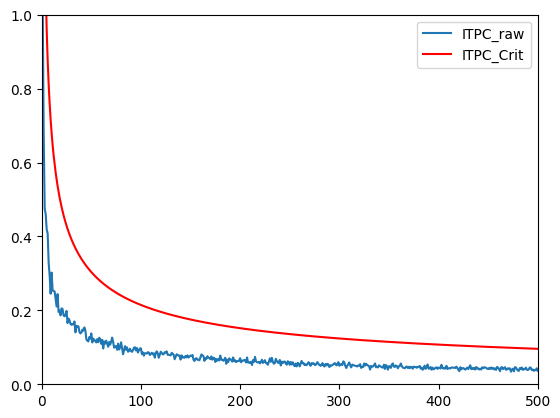

In [85]:
# Figure 19.5

n_trials = 500
itpcByNFake = np.zeros(n_trials)

for n in range(1, n_trials+1):
    for iteri in range(50):
        itpcByNFake[n-1] += np.abs(np.mean(np.exp(1j*(rand(n)*2*np.pi-np.pi))))

itpcByNFake /= iteri

# Z and P
itpcByNFakeZ = np.arange(1, n_trials+1) * (itpcByNFake**2)
itpcByNFakeP = np.exp(np.sqrt(1 + 4*np.arange(1, n_trials+1) + 4*((np.arange(1, n_trials+1)**2) - (np.arange(1, n_trials+1)*itpcByNFake)**2)) - (1 + 2*np.arange(1, n_trials+1)))
itpcFakeCrit = np.sqrt(-np.log(0.01) / np.arange(1, n_trials+1))

plt.figure()
plt.plot(np.arange(1, n_trials+1), itpcByNFake)
plt.plot(np.arange(1, n_trials+1), itpcFakeCrit, 'r')
plt.xlim([0, 500])
plt.ylim([0, 1])
plt.legend(['ITPC_raw', 'ITPC_Crit'])
plt.show()

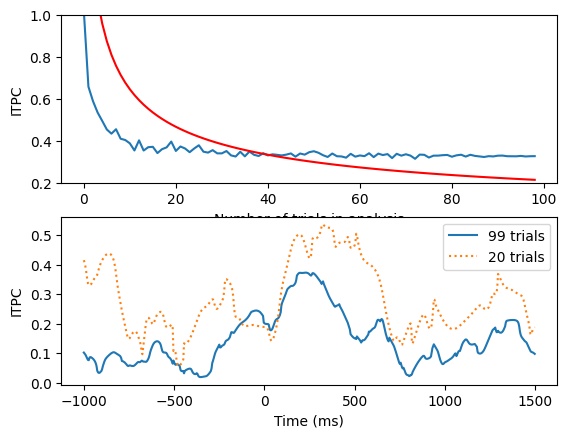

In [ ]:
# Figure 19.6

# Center frequency
centerfreq = 6  # Hz
chan2plot = 'FCz'

# Define convolution parameters
n_wavelet = EEG['pnts'][0][0]
n_data = EEG['pnts'][0][0] * EEG['trials'][0][0]
n_convolution = n_wavelet + n_data
n_conv_pow2 = 2**np.ceil(np.log2(n_convolution))

# Create wavelet
wavelet = np.exp(2*1j*np.pi*centerfreq*time) * np.exp(-time**2 / (2 * ((4 / (2 * np.pi * centerfreq))**2))) / centerfreq

# Get FFT of data
chanidx = EEG['chanlocs'][0]['labels']==chan2plot
eegfft = fft(np.reshape(EEG['data'][chanidx,:,:], -1, 'F'), n=int(n_conv_pow2))

# Convolution
eegconv = ifft(fft(wavelet, n=int(n_conv_pow2)) * eegfft)
eegconv = eegconv[:n_convolution]
eegconv = np.reshape(eegconv[int(np.ceil((n_wavelet-1)/2)):-int(np.ceil((n_wavelet-1)/2))], (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')

plt.figure()

# Compute ITPC as function of N
itpcByN = np.zeros(EEG['trials'][0][0])
for n in range(1, EEG['trials'][0][0]+1):
    for iteri in range(50):
        trials2use = choice(EEG['trials'][0][0], n, replace=False)
        itpcByN[n-1] += np.mean(np.abs(np.mean(np.exp(1j*np.angle(eegconv[282:372, trials2use])), axis=1)))
itpcByN /= iteri

# Z and P
itpcByNZ = np.arange(1, EEG['trials'][0][0]+1) * (itpcByN**2)
itpcByNP = np.exp(np.sqrt(1 + 4*np.arange(1, EEG['trials'][0][0]+1) + 4*((np.arange(1, EEG['trials'][0][0]+1)**2) - (np.arange(1, EEG['trials'][0][0]+1)*itpcByN)**2)) - (1 + 2*np.arange(1, EEG['trials'][0][0]+1)))
itpcCrit = np.sqrt(-np.log(0.01) / np.arange(1, EEG['trials'][0][0]+1))

plt.subplot(211)
plt.plot(itpcByN)
plt.plot(itpcCrit, 'r')
plt.xlabel('Number of trials in analysis')
plt.ylabel('ITPC')
plt.ylim([0.2, 1])

# Note that this figure will look different than that in the book because trials are randomly selected.
plt.subplot(212)
plt.plot(EEG['times'][0], np.abs(np.mean(np.exp(1j*np.angle(eegconv)), axis=1)))
randomtrials2plot = np.random.permutation(EEG['trials'][0][0])
plt.plot(EEG['times'][0], np.abs(np.mean(np.exp(1j*np.angle(eegconv[:, randomtrials2plot[:20]])), axis=1)), ':')
plt.xlabel('Time (ms)')
plt.ylabel('ITPC')
plt.legend(['99 trials', '20 trials'])
plt.show()

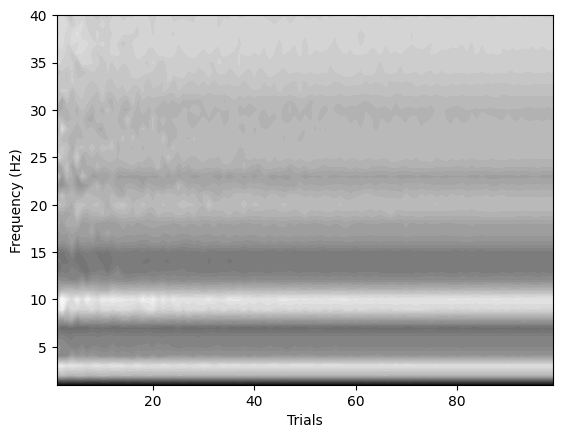

In [149]:
# Figure 19.7

# Center frequencies
frequencies = np.arange(1, 41)

niterations = 50

# Initialize
itpcByNandF = np.zeros((len(frequencies), EEG['trials'][0][0]))

for fi, freq in enumerate(frequencies):
    centerfreq = freq
    wavelet = np.exp(2*1j*np.pi*centerfreq*time) * np.exp(-time**2 / (2 * ((4 / (2 * np.pi * centerfreq))**2))) / centerfreq
    
    # Convolution
    eegconv = ifft(fft(wavelet, n=int(n_conv_pow2)) * eegfft)
    eegconv = eegconv[:n_convolution]
    eegconv = np.reshape(eegconv[int(np.ceil((n_wavelet-1)/2)):-int(np.ceil((n_wavelet-1)/2))], (EEG['pnts'][0][0], EEG['trials'][0][0]))
    
    for n in range(1, EEG['trials'][0][0]+1):
        for iteri in range(niterations):
            trials2use = choice(EEG['trials'][0][0], n, replace=False)
            itpcByNandF[fi, n-1] += np.mean(np.abs(np.mean(np.exp(1j*np.angle(eegconv[282:372, trials2use])), axis=0)))

plt.figure()
plt.contourf(np.arange(1, EEG['trials'][0][0]+1), frequencies, itpcByNandF / iteri, 40, cmap='gray')
# plt.clim([0.1, 0.5])
plt.xlabel('Trials')
plt.ylabel('Frequency (Hz)')
plt.show()

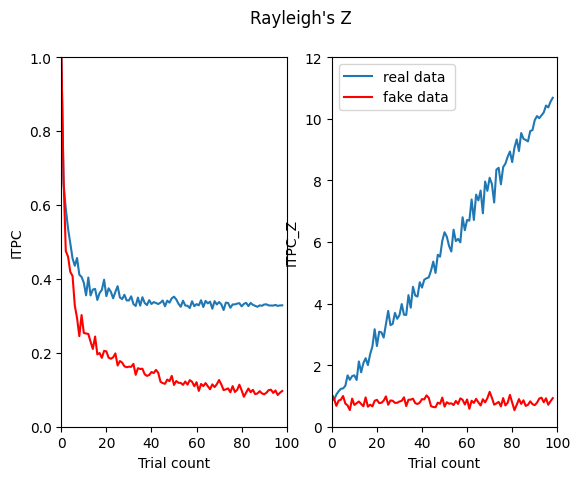

In [155]:
# Figure 19.8

plt.figure()
plt.suptitle("Rayleigh's Z")

plt.subplot(121)
plt.plot(itpcByN)
plt.plot(itpcByNFake[:99], 'r')
plt.xlim([0, 100])
plt.ylim([0, 1])
plt.xlabel('Trial count')
plt.ylabel('ITPC')

plt.subplot(122)
plt.plot(itpcByNZ)
plt.plot(itpcByNFakeZ[:99], 'r')
plt.xlim([0, 100])
plt.ylim([0, 12])
plt.xlabel('Trial count')
plt.ylabel('ITPC_Z')
plt.legend(['real data', 'fake data'])
plt.show()

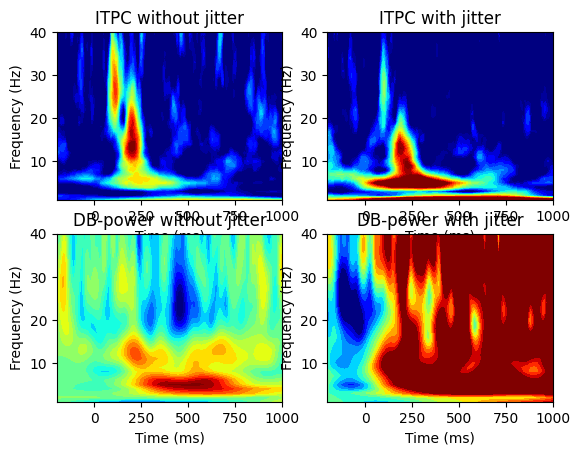

In [166]:
# Figure 19.9

# Pick electrode and frequencies
chan2plot = 'FCz'
frequencies = np.arange(1, 41)

# Define convolution parameters
time = np.arange(-(EEG['pnts'][0][0]/EEG['srate'][0][0]/2), EEG['pnts'][0][0]/EEG['srate'][0][0]/2, 1/EEG['srate'][0][0])
n_wavelet = EEG['pnts'][0][0]
n_data = EEG['pnts'][0][0] * EEG['trials'][0][0]
n_convolution = n_wavelet + n_data - 1
n_conv_pow2 = 2**np.ceil(np.log2(n_convolution))

plotlegends = ['without jitter', 'with jitter']

plt.figure()

baselinetime = [-300, -100]
baseidx = np.searchsorted(EEG['times'][0], baselinetime)

for simuli in range(1, 3):
    # Add time jitter (or not)
    tempdat = EEG['data'][EEG['chanlocs'][0]['labels']==chan2plot, :, :]
    if simuli == 2:
        for ti in range(tempdat.shape[1]):
            timejitter = int(np.ceil(rand() * 10))
            tempdat[:, ti] = np.roll(tempdat[:, ti], timejitter)
    
    # Get FFT of data
    eegfft = fft(np.reshape(tempdat, -1, 'F'), n=int(n_conv_pow2))

    # Initialize
    itpc = np.zeros((len(frequencies), EEG['pnts'][0][0]))
    powr = np.zeros((len(frequencies), EEG['pnts'][0][0]))
    
    for fi, freq in enumerate(frequencies):
        centerfreq = freq
        wavelet = np.exp(2*1j*np.pi*centerfreq*time) * np.exp(-time**2 / (2 * ((4 / (2 * np.pi * centerfreq))**2))) / centerfreq
        
        # Convolution
        eegconv = ifft(fft(wavelet, n=int(n_conv_pow2)) * eegfft)
        eegconv = eegconv[:n_convolution]
        eegconv = np.reshape(eegconv[int(np.floor((n_wavelet-1)/2)):-int(np.ceil((n_wavelet-1)/2))], (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
        
        # Compute and store ITPC and power
        itpc[fi, :] = np.abs(np.mean(np.exp(1j*np.angle(eegconv)), axis=1))
        powr[fi, :] = np.mean(np.abs(eegconv)**2, axis=1)
        powr[fi, :] = 10 * np.log10(powr[fi, :] / np.mean(powr[fi, baseidx])) # axis=1?
    
    plt.subplot(2, 2, simuli)
    plt.contourf(EEG['times'][0], frequencies, itpc, 40, cmap='jet')
    plt.clim([0.1, 0.5])
    plt.xlim([-200, 1000])
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'ITPC {plotlegends[simuli-1]}')
    
    plt.subplot(2, 2, simuli+2)
    plt.contourf(EEG['times'][0], frequencies, powr, 40, cmap='jet')
    plt.clim([-3, 3])
    plt.xlim([-200, 1000])
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'DB-power {plotlegends[simuli-1]}')

plt.show()

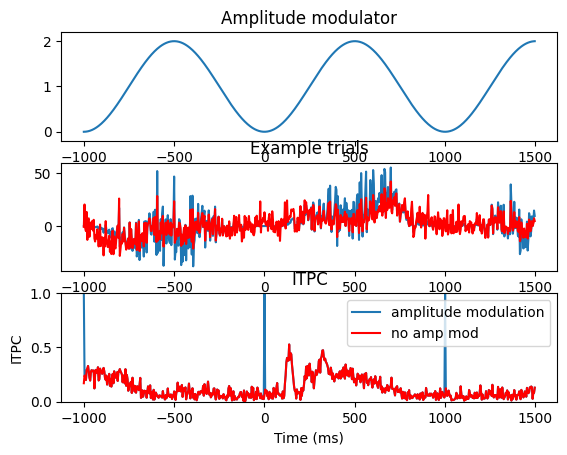

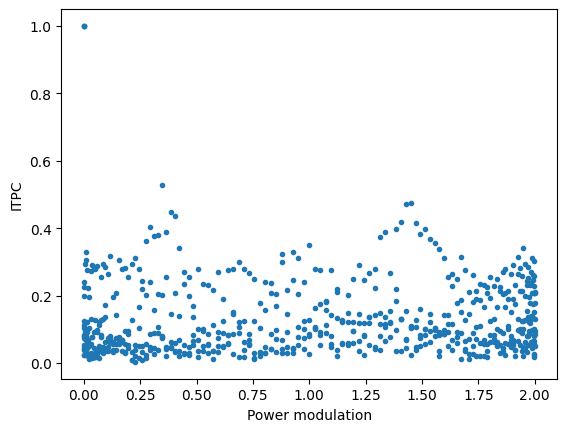

In [169]:
# Figure 19.10

# Initialize
data4test = np.zeros((2, len(time), EEG['trials'][0][0]))
sensor2use = 'P7'

# Amplitude modulation (modulate power by 1 Hz sine wave)
amp_mod = (np.sin(2*np.pi*1.*time) + 2) - 1

for triali in range(EEG['trials'][0][0]):
    # Each trial is a random channel and trial
    trialdata = EEG['data'][EEG['chanlocs'][0]['labels']==sensor2use, :, triali]
    
    # Uncomment the next line of code for band-pass filtered data.
    # This uses the eegfilt function, which is part of the eeglab toolbox.
    # trialdata = eegfilt(double(trialdata), EEG['srate'][0][0], 10, 20)
    
    data4test[0, :, triali] = trialdata * amp_mod
    data4test[1, :, triali] = trialdata

# Compute ITPC
itpc_mod = np.abs(np.mean(np.exp(1j*np.angle(hilbert(data4test[0, :, :]))), axis=1))
itpc_nomod = np.abs(np.mean(np.exp(1j*np.angle(hilbert(data4test[1, :, :]))), axis=1))

# Plot!
plt.figure()

plt.subplot(311)
plt.plot(EEG['times'][0], amp_mod)
plt.ylim([-.2, 2.2])
plt.title('Amplitude modulator')

plt.subplot(312)
plt.plot(EEG['times'][0], data4test[0, :, 10])
plt.plot(EEG['times'][0], data4test[1, :, 10], 'r')
plt.axis('tight')
plt.title('Example trials')

plt.subplot(313)
plt.plot(EEG['times'][0], itpc_mod)
plt.plot(EEG['times'][0], itpc_nomod, 'r')
plt.legend(['amplitude modulation', 'no amp mod'])
plt.ylim([0, 1])
plt.xlabel('Time (ms)')
plt.ylabel('ITPC')
plt.title('ITPC')

plt.figure()
plt.plot(amp_mod, itpc_mod, '.')
plt.xlabel('Power modulation')
plt.ylabel('ITPC')
plt.show()

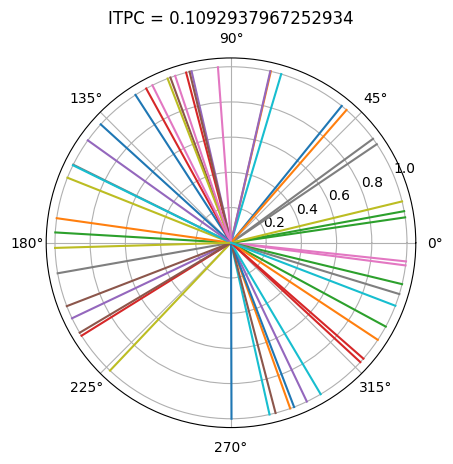

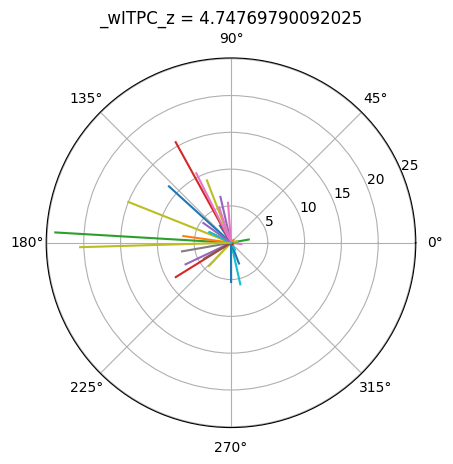

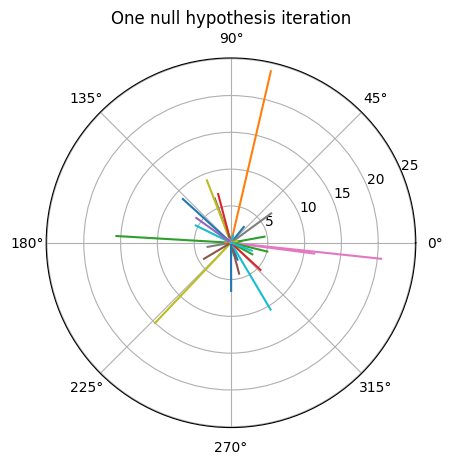

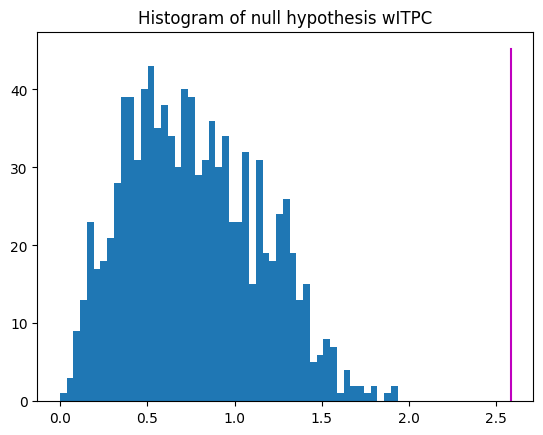

In [175]:
# Figure 19.11

randvects = rand(50) * 2 * np.pi - np.pi
vectormod = (randvects + randn(50))**2
vectormod2 = vectormod - np.min(vectormod) + 1  # make sure no negative values


# ITPC
plt.figure()
plot_polar_vectors(randvects, np.ones_like(randvects))
plt.title(f'ITPC = {np.abs(np.mean(np.exp(1j*randvects)))}')

# wITPC
plt.figure()
plot_polar_vectors(randvects, vectormod)

witpc = np.abs(np.mean(vectormod * np.exp(1j*randvects)))
perm_witpc = np.zeros(1000)

for i in range(1000):
    perm_witpc[i] = np.abs(np.mean(vectormod[np.random.permutation(len(vectormod))] * np.exp(1j*randvects)))

witpc_z = (witpc - np.mean(perm_witpc)) / np.std(perm_witpc)
plt.title(f'_wITPC_z = {witpc_z}')

# Example of one permutation
plt.figure()
plot_polar_vectors(randvects, vectormod[np.random.permutation(len(vectormod))])
plt.title('One null hypothesis iteration')

# Histogram of null-hypothesis WITPC
plt.figure()
y, x = np.histogram(perm_witpc, bins=50)
plt.bar(x[:-1], y, width=np.diff(x), edgecolor='none')
plt.plot([witpc, witpc], plt.gca().get_ylim(), 'm')
plt.title('Histogram of null hypothesis wITPC')
plt.show()

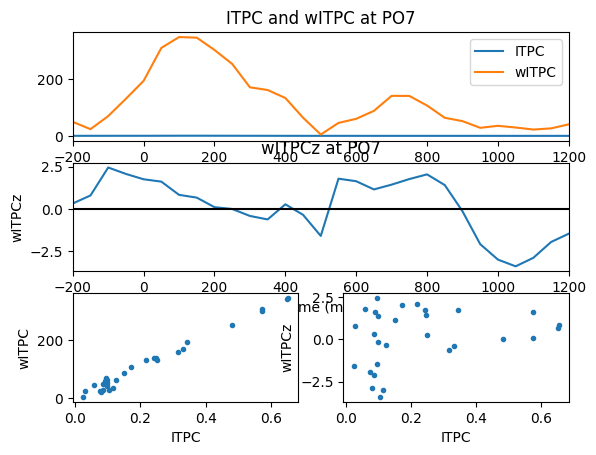

In [177]:
# Figure 19.12

centerfreq = 6
channel2use = 'PO7'
times2save = np.arange(-200, 1201, 50)

# Initialize matrix to store RTs
rts = np.zeros(EEG['trials'][0][0])

for ei in range(EEG['trials'][0][0]):
    # Find which event is time=0, and take the latency of the event thereafter.
    time0event = np.where(np.array(EEG['epoch'][0][ei]['eventlatency'][0]) == 0)[0][0]
    
    # Use try-except in case of no response
    try:
        rts[ei] = EEG['epoch'][0][ei]['eventlatency'][0][time0event + 1]
    except IndexError:
        rts[ei] = np.nan

# Get FFT of data and wavelet
chanidx = EEG['chanlocs'][0]['labels']==channel2use
eegfft = fft(np.reshape(EEG['data'][chanidx,:,:], -1, 'F'), n=int(n_conv_pow2))
wavefft = fft(np.exp(2*1j*np.pi*centerfreq*time) * np.exp(-time**2 / (2 * ((4 / (2 * np.pi * centerfreq))**2))), n=int(n_conv_pow2))

# Convolution
eegconv = ifft(wavefft * eegfft)
eegconv = eegconv[:n_convolution]
eegconv = np.reshape(eegconv[int(np.floor((n_wavelet-1)/2)):-int(np.ceil((n_wavelet-1)/2))], (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')

phase_angles = np.angle(eegconv)

# Initialize
itpc = np.zeros(len(times2save))
witpc = np.zeros(len(times2save))
witpc_z = np.zeros(len(times2save))

for ti, timepoint in enumerate(times2save):
    # Find index for this time point
    timeidx = np.argmin(np.abs(EEG['times'][0] - timepoint))
    
    # ITPC is unmodulated phase clustering
    itpc[ti] = np.abs(np.mean(np.exp(1j*phase_angles[timeidx,:])))
    
    # wITPC is rts modulating the length of phase angles
    witpc[ti] = np.abs(np.mean(rts * np.exp(1j*phase_angles[timeidx,:])))
    
    # Permutation testing
    perm_witpc = np.zeros(1000)
    for i in range(1000):
        perm_witpc[i] = np.abs(np.mean(rts[np.random.permutation(EEG['trials'][0][0])] * np.exp(1j*phase_angles[timeidx,:])))
    
    witpc_z[ti] = (witpc[ti] - np.mean(perm_witpc)) / np.std(perm_witpc)

plt.figure()

# Plot ITPC
plt.subplot(311)
plt.plot(EEG['times'][0], np.abs(np.mean(np.exp(1j*phase_angles), axis=1)))
plt.plot(times2save, witpc)
plt.xlim([times2save[0], times2save[-1]])
plt.title(f'ITPC and wITPC at {channel2use}')
plt.legend(['ITPC', 'wITPC'])

# Plot wITPCz
plt.subplot(312)
plt.plot(times2save, witpc_z)
plt.plot([times2save[0], times2save[-1]], [0, 0], 'k')
plt.xlim([times2save[0], times2save[-1]])
plt.xlabel('Time (ms)')
plt.ylabel('wITPCz')
plt.title(f'wITPCz at {channel2use}')

plt.subplot(325)
plt.plot(itpc, witpc, '.')
plt.xlabel('ITPC')
plt.ylabel('wITPC')

plt.subplot(326)
plt.plot(itpc, witpc_z, '.')
plt.xlabel('ITPC')
plt.ylabel('wITPCz')

plt.show()